In [6]:
%pip install torch torchvision
%pip install torchshow
%pip install albumentations
%pip install pandas
%pip install opencv-python
%pip install tqdm
# imgaug несовместим с NumPy 2.0, поэтому убираем его установку
# Если нужен imgaug, установите numpy<2.0: %pip install "numpy<2.0"


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-2.3.3-cp314-cp314-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp314-cp314-macosx_11_0_arm64.whl (10.8 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.
  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl (37.9 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached tqdm-4.67.1-py3-none-an

In [7]:
import torch
from torch import optim, nn
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import os
import pandas as pd
from PIL import Image #pip install pillow 
import albumentations as A

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
# Загрузка предобученной модели ResNet-18
model = models.resnet18(weights='IMAGENET1K_V1')
model.eval()

for name, child in model.named_children():
  print(name)


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [9]:
# Определение путей к данным
train_dir = 'dataset/train'
valid_dir = 'dataset/valid'
test_dir = 'dataset/test'


In [10]:
# !pip install opencv-python
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


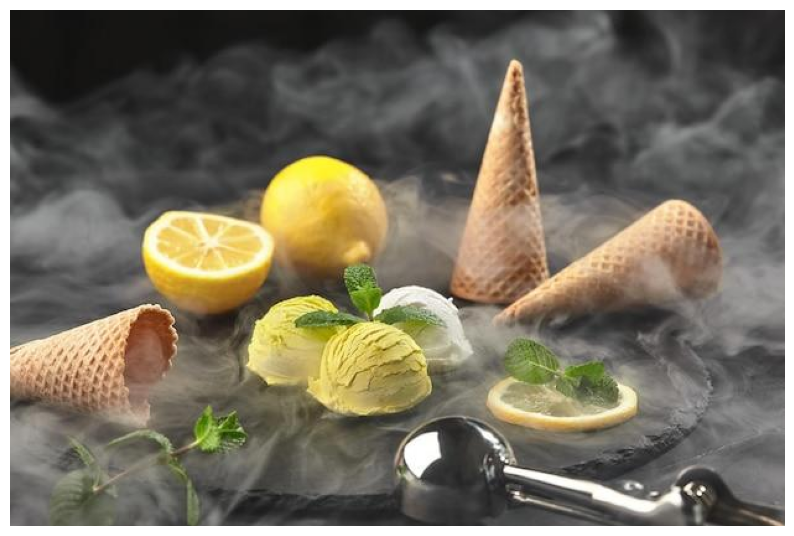

In [11]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

# Загружаем пример изображения из датасета
import glob
icecream_images = glob.glob(train_dir + '/icecream/*.jpg')
if icecream_images:
    image = cv2.imread(icecream_images[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    visualize(image)


/Users/n0tsszzz/hotDog_recognition/.venv/lib/python3.14/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


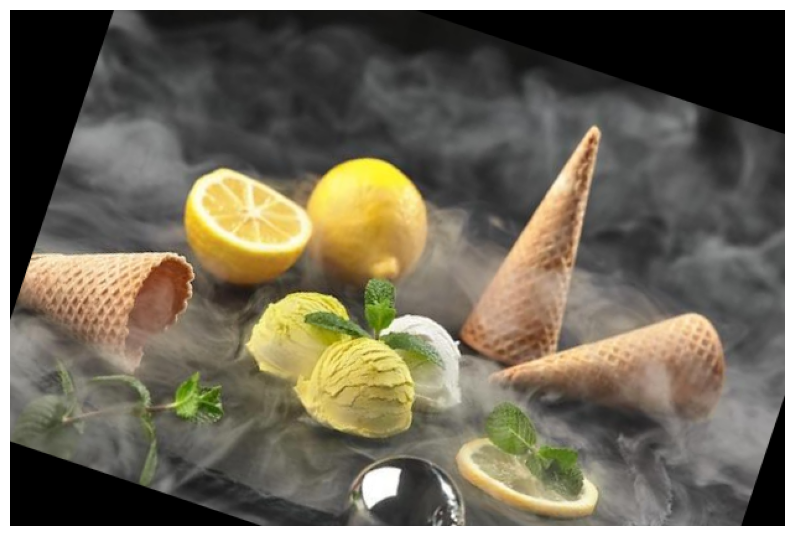

In [12]:
tt = A.ShiftScaleRotate(p=0.85)
aug = tt(image=image)
# print(aug)

augmented_image = aug['image']
visualize(augmented_image)


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 35, 25

def show_dataset(dataset, n=8):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')


In [14]:
def load_model(path, model, optimizer):

  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model, optimizer


In [15]:
import torch
from torch import nn
from torch.optim import lr_scheduler
from tqdm.auto import tqdm
import numpy as np


def train_and_test(
    model,
    trainloader,
    validloader,
    epochs,
    path,
    patience=5,      # early stopping patience
    min_delta=0.0    # improvement threshold
):

    device = next(model.parameters()).device

    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001
    )
    scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(epochs):

        # ---------------- TRAIN ----------------
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} [train]")

        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # ---------------- VALIDATION ----------------
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            val_pbar = tqdm(validloader, desc=f"Epoch {epoch+1}/{epochs} [val]")

            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)

                logps = model(images)
                loss = criterion(logps, labels)
                val_loss += loss.item()

                ps = torch.exp(logps)
                _, preds = ps.topk(1, dim=1)

                preds = preds.squeeze()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(validloader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)

        scheduler.step()

        print(f"\nEpoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f}")

        # ---------------- EARLY STOPPING ----------------
        if avg_val_loss < best_val_loss - min_delta:
            print(f"Validation loss improved {best_val_loss:.4f} → {avg_val_loss:.4f}. Saving model.")
            best_val_loss = avg_val_loss
            epochs_no_improve = 0

            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("\n⚠ Early stopping triggered. Training stopped.")
                break

    return train_losses, val_losses


/Users/n0tsszzz/hotDog_recognition/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt


def train_model(model, train_dataset, valid_dataset, epochs=10, batch_size=16, save_path="./icecream_pizza_model.pt"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Train
    train_losses, val_losses = train_and_test(
        model=model,
        trainloader=train_loader,
        validloader=valid_loader,
        epochs=epochs,
        path=save_path,
        patience=5,
        min_delta=0.0
    )

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    print("Training finished. Best model saved to:", save_path)

    return model


In [17]:
def test_model(model, test_data, batch_size=16):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    testloader = DataLoader(test_data, batch_size=batch_size)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")

    return acc


In [18]:
from torch.optim import lr_scheduler

def get_model(device):
  model = models.resnet18(weights='IMAGENET1K_V1') ##

  hidd_size = model.fc.in_features // 3
  model.fc = nn.Sequential(nn.Linear(model.fc.in_features, hidd_size), nn.ReLU(), nn.Linear(hidd_size, 2),
                           nn.LogSoftmax(dim=1))    # criterion = nn.NLLLoss()

  # for param in model.parameters():
  #     param.requires_grad = False
    
  for name, child in model.named_children():
    if name in ['layer3', 'layer4', 'fc']:
      print(name + ' is unfrozen')
      for param in child.parameters():
        param.requires_grad = True
    else:
      print(name + ' is frozen')
      for param in child.parameters():
        param.requires_grad = False

  model.to(device)
  return model


Визуализируем батч из валидационного набора и весь train по батчам


validation examples contain : 208


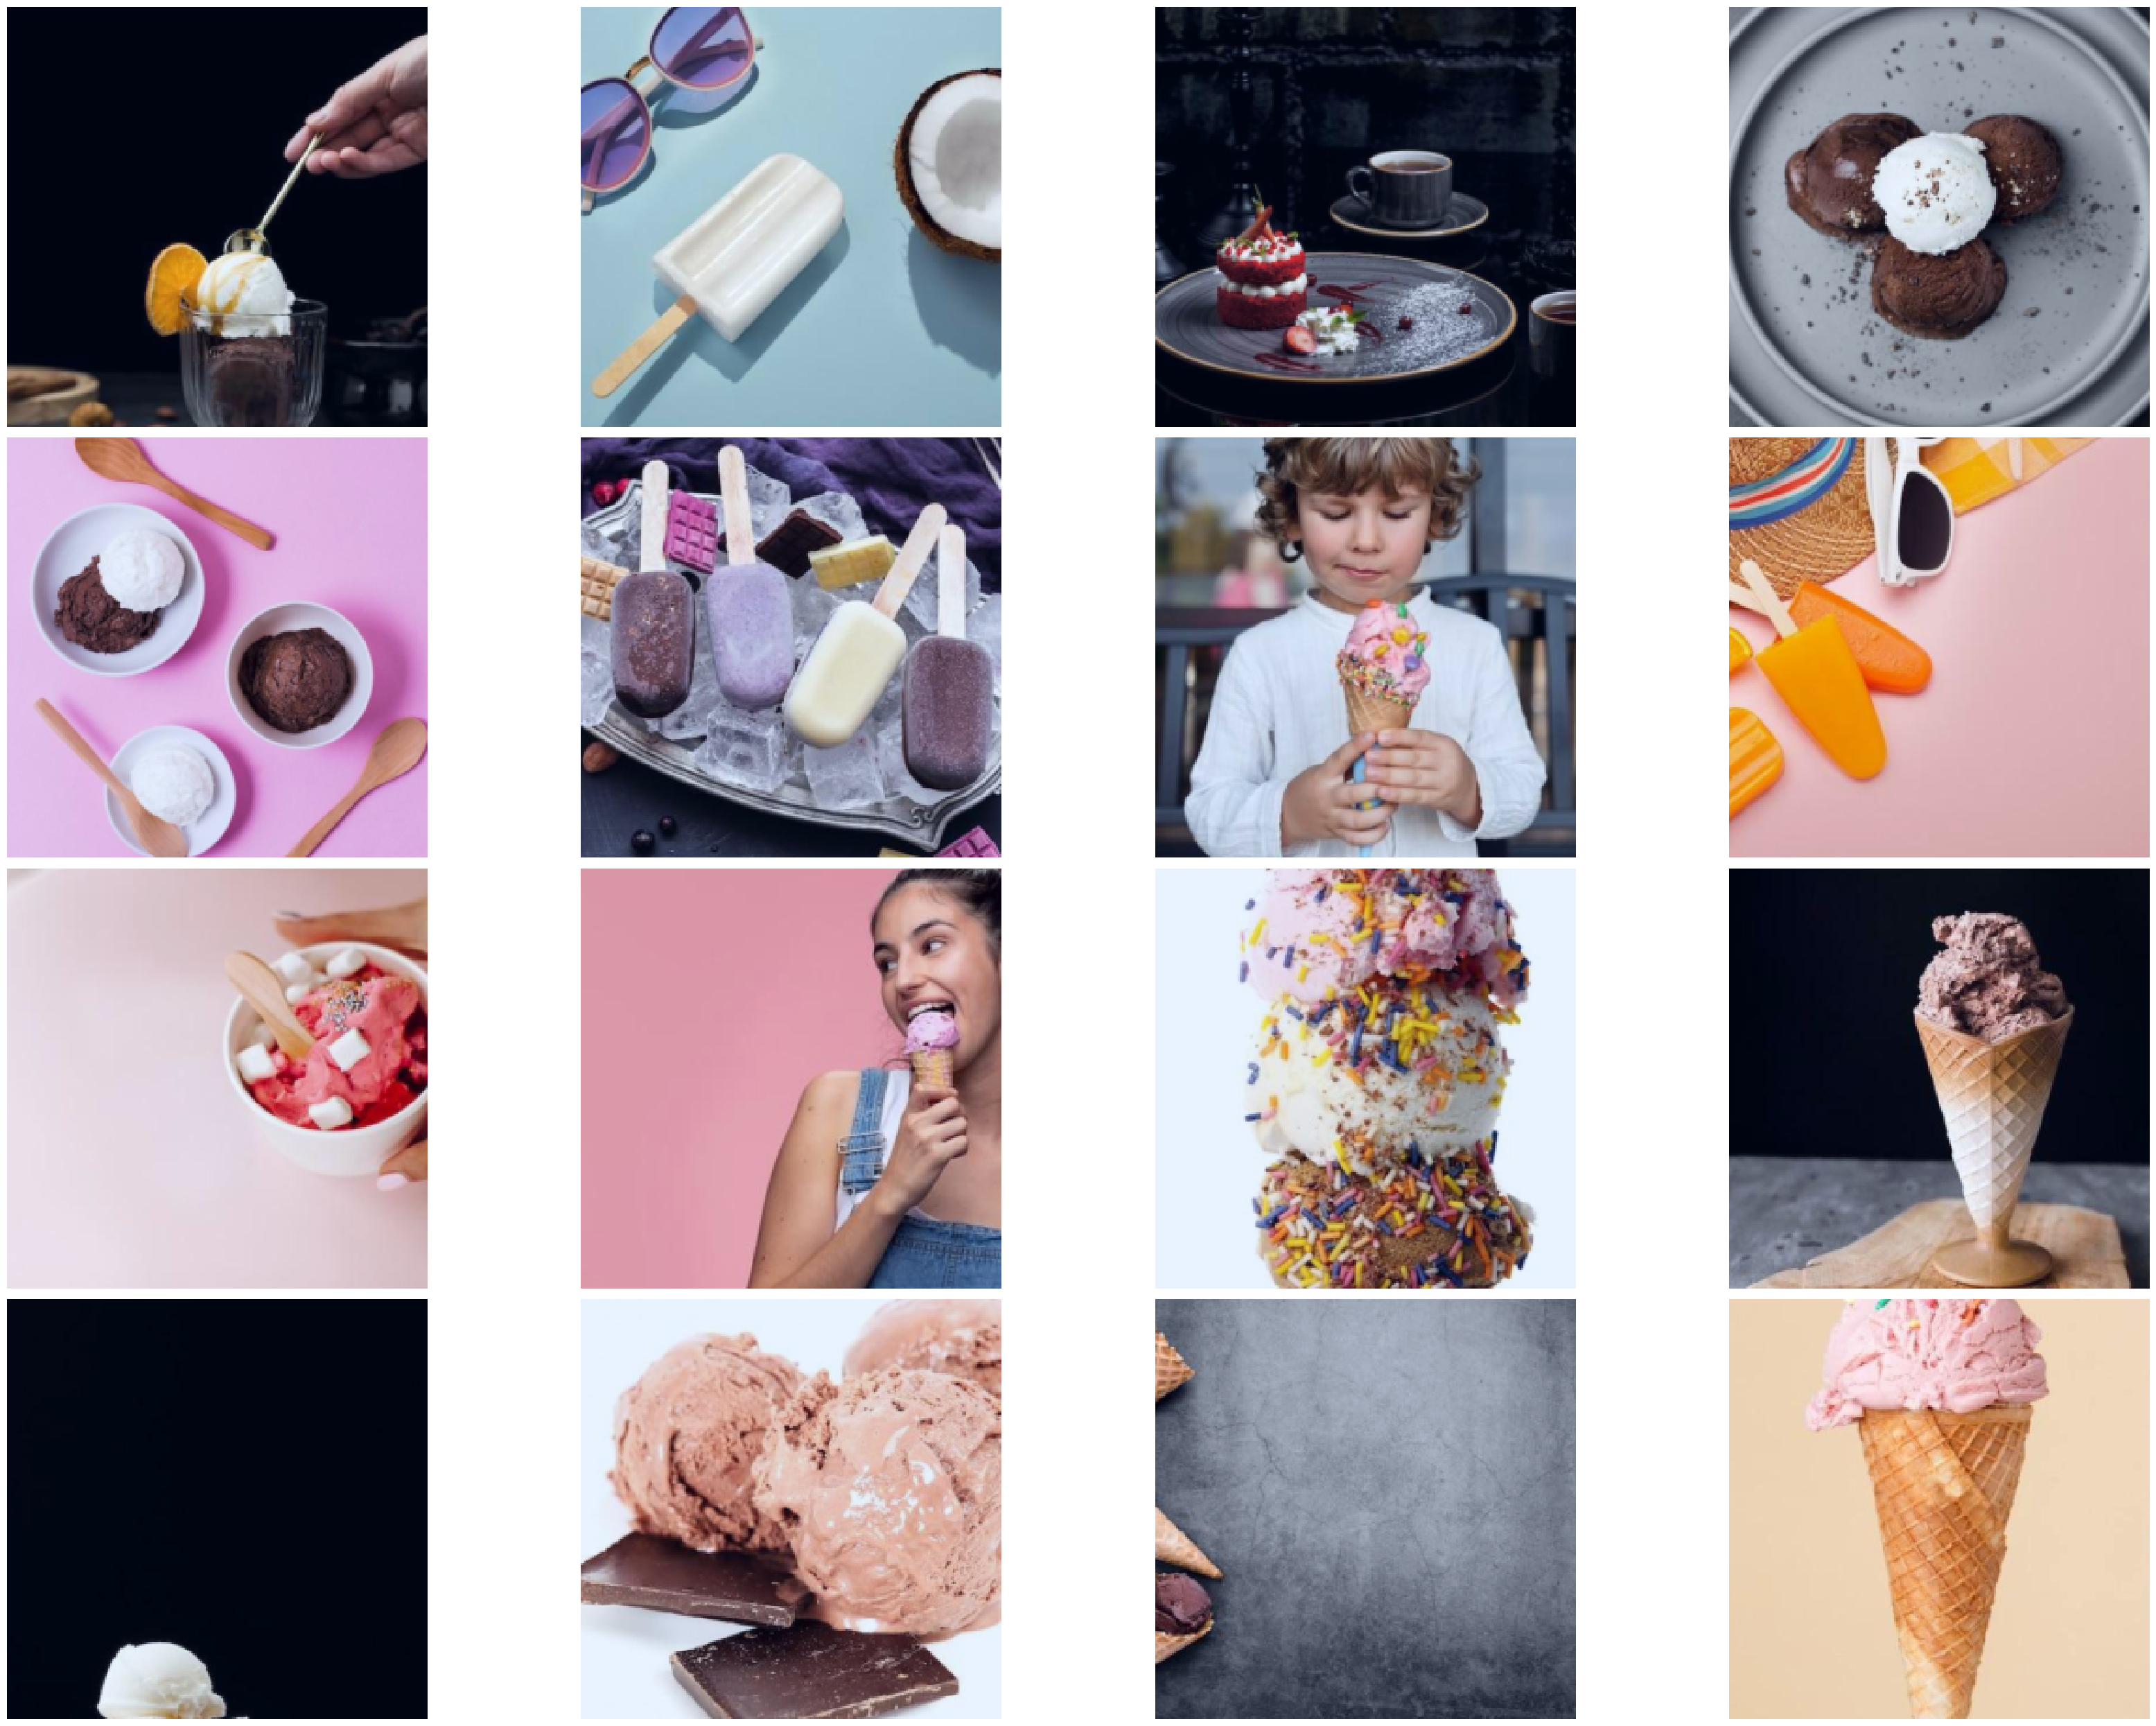

In [19]:
import torchshow as ts

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16)
images, labels = next(iter(validloader))
ts.show(images)
print(f"validation examples contain : {len(valid_data)}")


training examples contain: 718


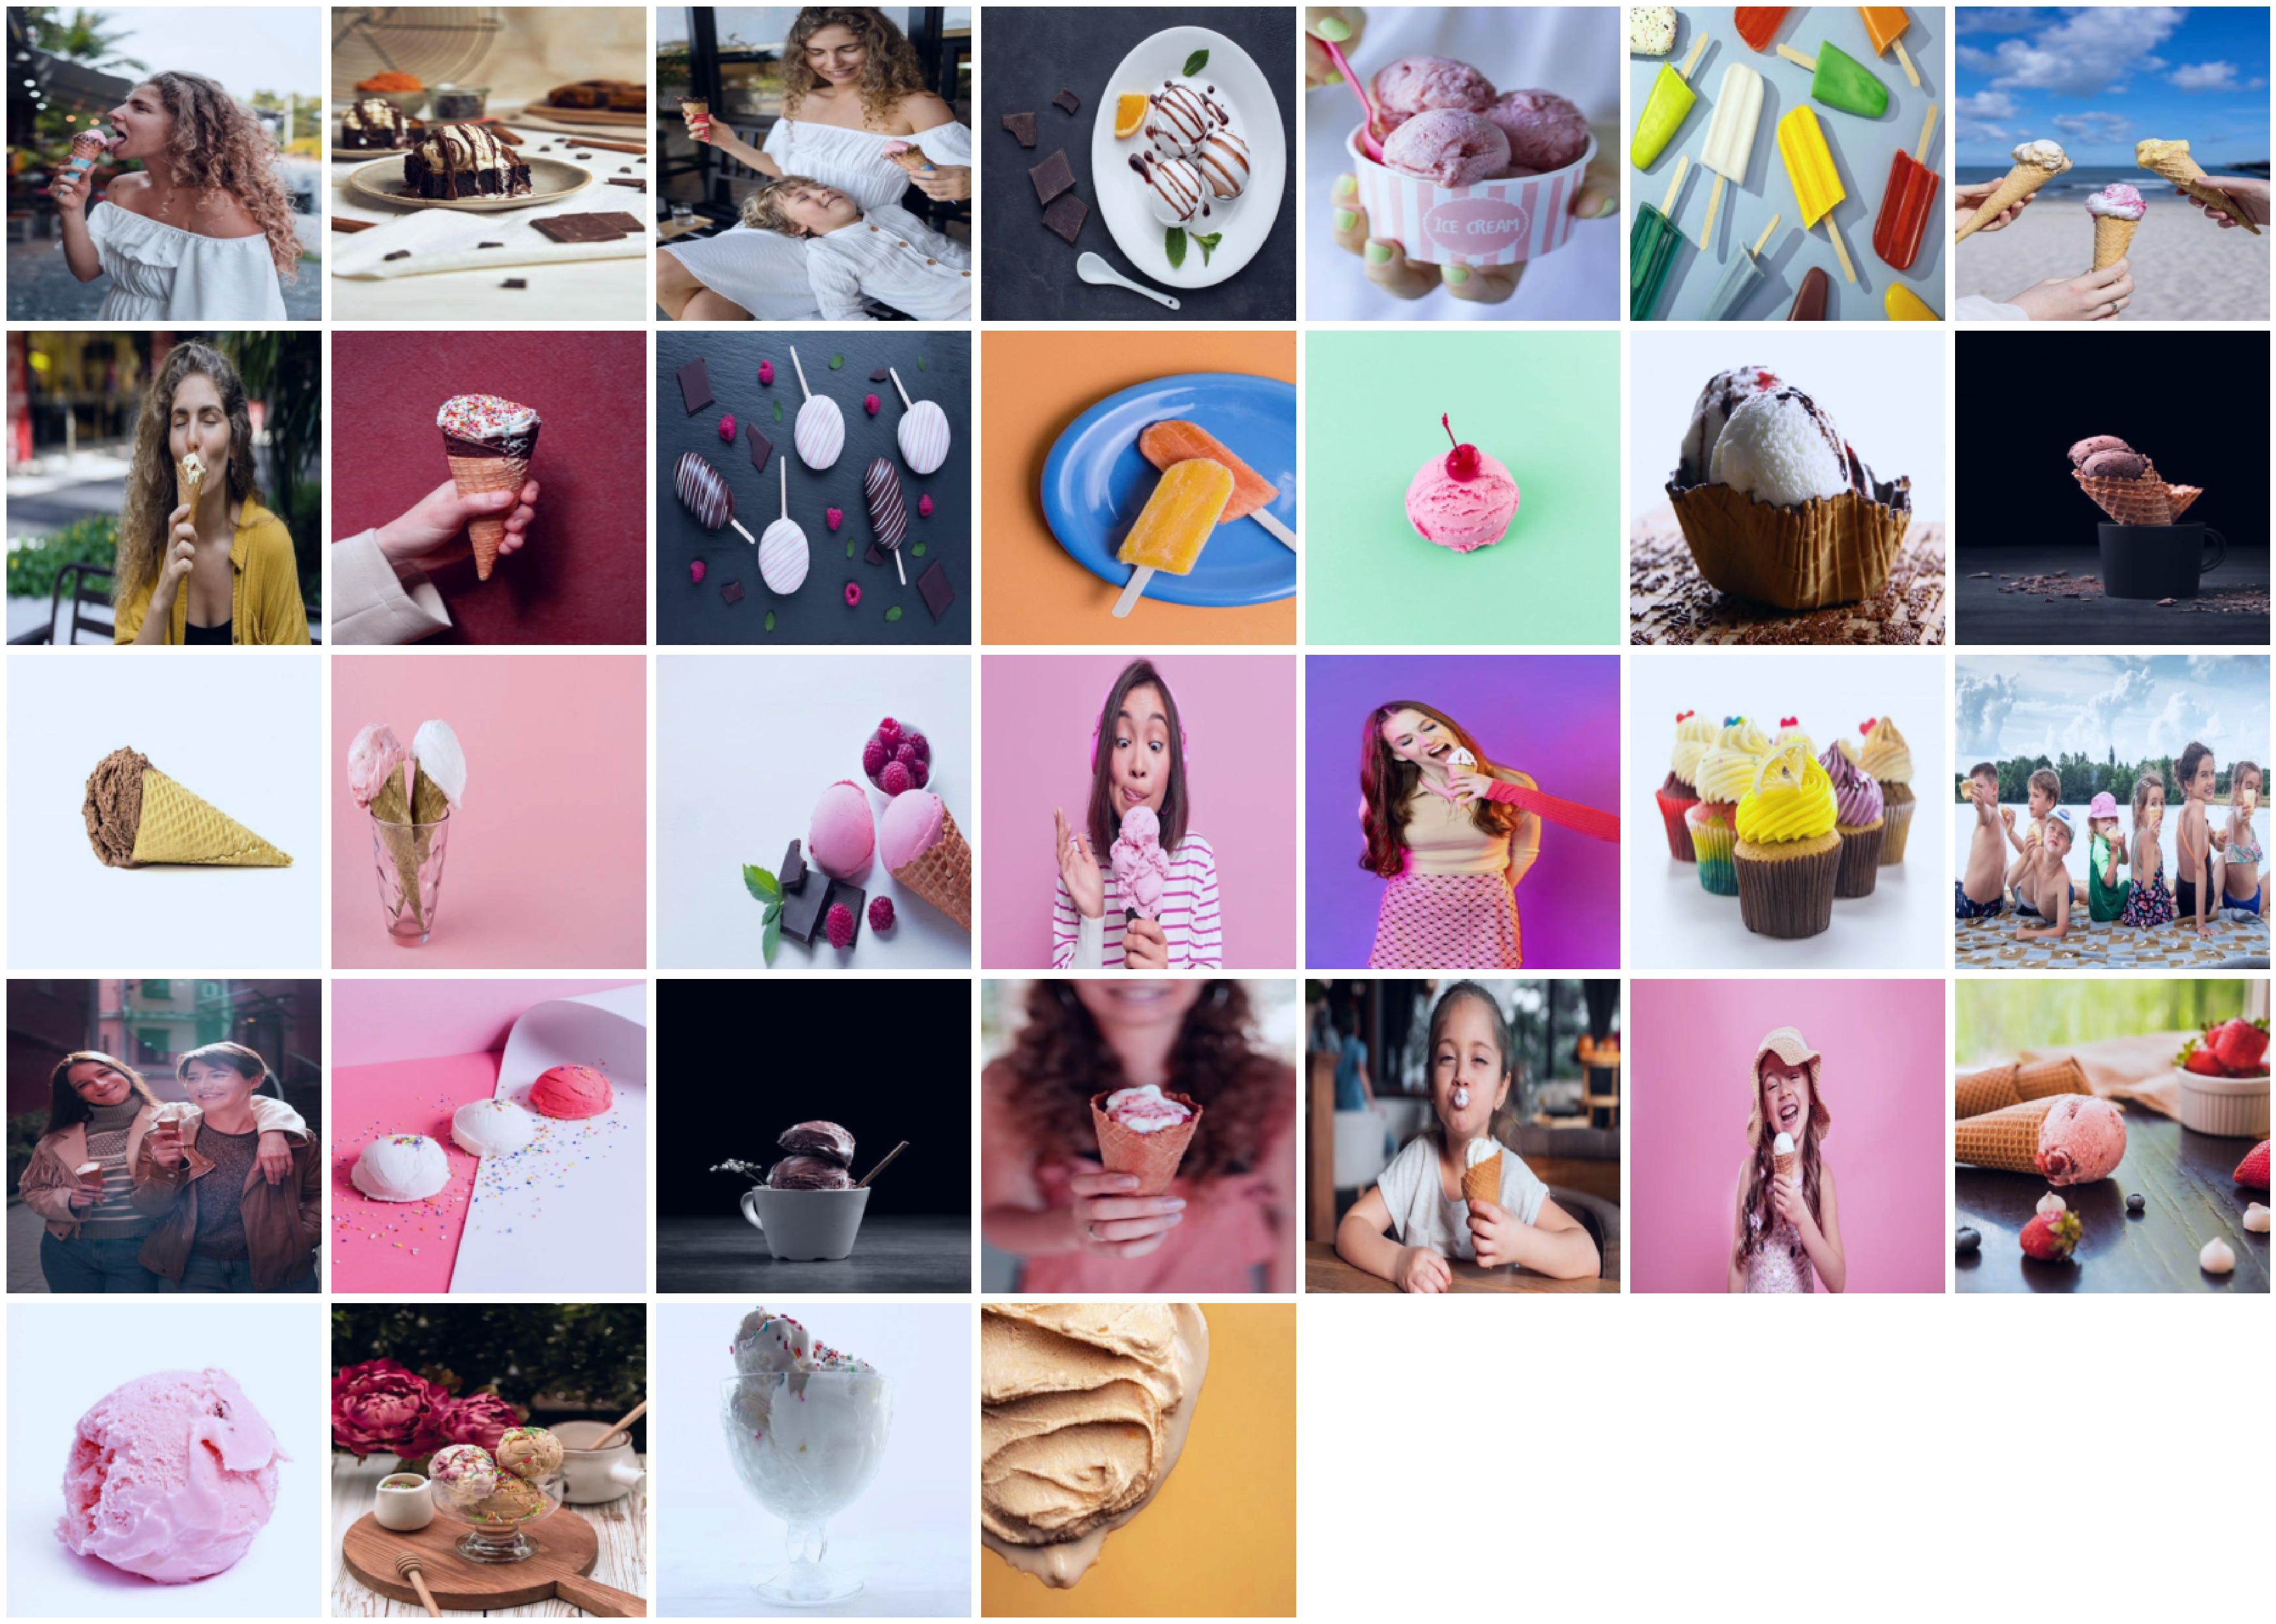

In [20]:
tr = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])]
)

td = datasets.ImageFolder(train_dir, transform=tr)
tl = torch.utils.data.DataLoader(td, batch_size=32)

for images, labels in tl:
  #print(images)
  ts.show(images)
  break

print(f"training examples contain: {len(td)}")


conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


Epoch 1/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]



Epoch 1/10 | Train Loss: 0.2450 | Val Loss: 0.2443 | Val Acc: 0.8750
Validation loss improved inf → 0.2443. Saving model.


Epoch 2/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 2/10 | Train Loss: 0.1552 | Val Loss: 0.1351 | Val Acc: 0.9375
Validation loss improved 0.2443 → 0.1351. Saving model.


Epoch 3/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 3/10 | Train Loss: 0.0894 | Val Loss: 0.2307 | Val Acc: 0.9327


Epoch 4/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]



Epoch 4/10 | Train Loss: 0.0800 | Val Loss: 0.1278 | Val Acc: 0.9423
Validation loss improved 0.1351 → 0.1278. Saving model.


Epoch 5/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]



Epoch 5/10 | Train Loss: 0.0669 | Val Loss: 0.1281 | Val Acc: 0.9663


Epoch 6/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]



Epoch 6/10 | Train Loss: 0.0795 | Val Loss: 0.2130 | Val Acc: 0.9279


Epoch 7/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]



Epoch 7/10 | Train Loss: 0.0366 | Val Loss: 0.1429 | Val Acc: 0.9567


Epoch 8/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]



Epoch 8/10 | Train Loss: 0.0224 | Val Loss: 0.1264 | Val Acc: 0.9663
Validation loss improved 0.1278 → 0.1264. Saving model.


Epoch 9/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]



Epoch 9/10 | Train Loss: 0.0161 | Val Loss: 0.1440 | Val Acc: 0.9615


Epoch 10/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch 10/10 | Train Loss: 0.0131 | Val Loss: 0.1206 | Val Acc: 0.9615
Validation loss improved 0.1264 → 0.1206. Saving model.


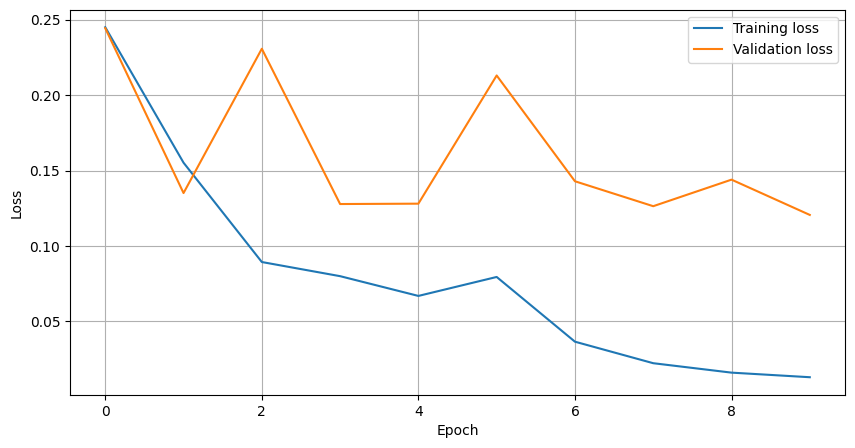

Training finished. Best model saved to: ./icecream_pizza_model.pt


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
model = get_model(device)
train_data = torchvision.datasets.ImageFolder(train_dir, transform=tr)
valid_data = torchvision.datasets.ImageFolder(valid_dir, transform=test_transforms)
train_model(model, train_data, valid_data)


In [22]:
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
test_model(model, test_data)


Test Accuracy: 0.9811


0.9811320754716981

In [23]:
df=pd.DataFrame()

tr_list = []
desc_list = []
acc_list = []

####
transforms0 = torchvision.transforms.Compose([
  torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
  torchvision.transforms.Resize((250,250)),
  torchvision.transforms.CenterCrop(224),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]
)
tr_list.append(transforms0)
desc_list.append("torchvision augs: colorJitter >> do color changes to more attention to shape")

transforms1 = torchvision.transforms.Compose([
  torchvision.transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
  torchvision.transforms.RandomPerspective(distortion_scale=0.2),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.Resize((250,250)),
  torchvision.transforms.CenterCrop(224),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]
)
tr_list.append(transforms1)
desc_list.append("torchvision augs: RandomAffine + RandomPerspective >> do some geometry augs")

import torchvision.transforms as T
tt2 = T.Compose([T.ToTensor(), T.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
                 T.Resize((250,250)), T.CenterCrop(224),
                 T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
tr_list.append(tt2)
desc_list.append("torchvision augs - The RandomErasing() transform randomly selects a rectangular region in an input image and erases its pixels")


>>>>>> torchvision augs: colorJitter >> do color changes to more attention to shape
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


Epoch 1/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]



Epoch 1/10 | Train Loss: 0.2530 | Val Loss: 0.4788 | Val Acc: 0.9038
Validation loss improved inf → 0.4788. Saving model.


Epoch 2/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 2/10 | Train Loss: 0.2073 | Val Loss: 0.1659 | Val Acc: 0.9279
Validation loss improved 0.4788 → 0.1659. Saving model.


Epoch 3/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 3/10 | Train Loss: 0.1314 | Val Loss: 0.1416 | Val Acc: 0.9567
Validation loss improved 0.1659 → 0.1416. Saving model.


Epoch 4/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 4/10 | Train Loss: 0.0566 | Val Loss: 0.1713 | Val Acc: 0.9423


Epoch 5/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 5/10 | Train Loss: 0.0562 | Val Loss: 0.1122 | Val Acc: 0.9615
Validation loss improved 0.1416 → 0.1122. Saving model.


Epoch 6/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 6/10 | Train Loss: 0.0785 | Val Loss: 0.1436 | Val Acc: 0.9471


Epoch 7/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 7/10 | Train Loss: 0.0240 | Val Loss: 0.1447 | Val Acc: 0.9519


Epoch 8/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 8/10 | Train Loss: 0.0170 | Val Loss: 0.1101 | Val Acc: 0.9567
Validation loss improved 0.1122 → 0.1101. Saving model.


Epoch 9/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]



Epoch 9/10 | Train Loss: 0.0268 | Val Loss: 0.0939 | Val Acc: 0.9712
Validation loss improved 0.1101 → 0.0939. Saving model.


Epoch 10/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 10/10 | Train Loss: 0.0082 | Val Loss: 0.1074 | Val Acc: 0.9712


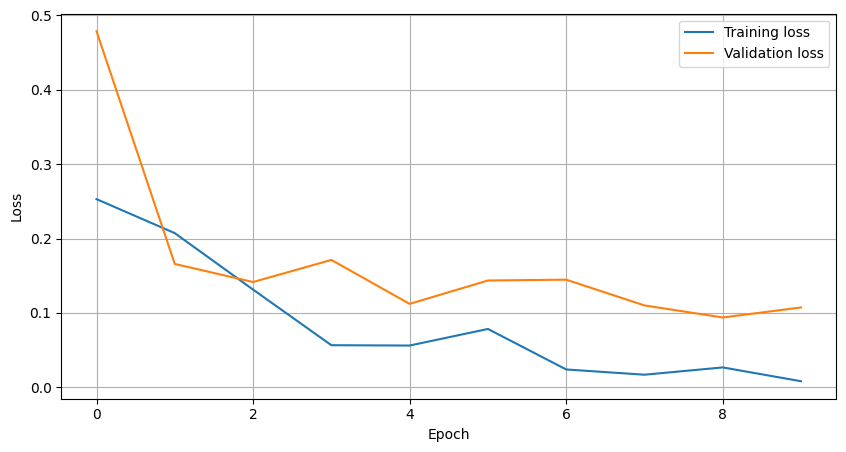

Training finished. Best model saved to: ./icecream_pizza_model_aug_0.pt
Test Accuracy: 0.9717
>>>>>> torchvision augs: RandomAffine + RandomPerspective >> do some geometry augs
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


Epoch 1/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 1/10 | Train Loss: 0.2808 | Val Loss: 0.1435 | Val Acc: 0.9471
Validation loss improved inf → 0.1435. Saving model.


Epoch 2/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]



Epoch 2/10 | Train Loss: 0.1480 | Val Loss: 0.2301 | Val Acc: 0.8990


Epoch 3/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 3/10 | Train Loss: 0.1458 | Val Loss: 0.2031 | Val Acc: 0.9375


Epoch 4/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 4/10 | Train Loss: 0.1431 | Val Loss: 0.1623 | Val Acc: 0.9519


Epoch 5/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]



Epoch 5/10 | Train Loss: 0.0739 | Val Loss: 0.0684 | Val Acc: 0.9808
Validation loss improved 0.1435 → 0.0684. Saving model.


Epoch 6/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]



Epoch 6/10 | Train Loss: 0.0623 | Val Loss: 0.1935 | Val Acc: 0.9471


Epoch 7/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 7/10 | Train Loss: 0.0440 | Val Loss: 0.0954 | Val Acc: 0.9615


Epoch 8/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 8/10 | Train Loss: 0.0266 | Val Loss: 0.0961 | Val Acc: 0.9663


Epoch 9/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]



Epoch 9/10 | Train Loss: 0.0442 | Val Loss: 0.0883 | Val Acc: 0.9663


Epoch 10/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch 10/10 | Train Loss: 0.0168 | Val Loss: 0.0869 | Val Acc: 0.9760

⚠ Early stopping triggered. Training stopped.


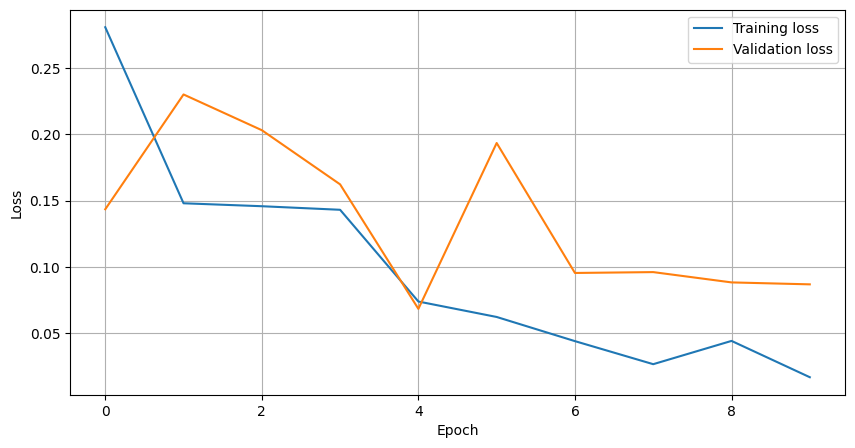

Training finished. Best model saved to: ./icecream_pizza_model_aug_1.pt
Test Accuracy: 0.9906
>>>>>> torchvision augs - The RandomErasing() transform randomly selects a rectangular region in an input image and erases its pixels
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


Epoch 1/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]



Epoch 1/10 | Train Loss: 0.2695 | Val Loss: 0.6340 | Val Acc: 0.8750
Validation loss improved inf → 0.6340. Saving model.


Epoch 2/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 2/10 | Train Loss: 0.1561 | Val Loss: 0.1392 | Val Acc: 0.9375
Validation loss improved 0.6340 → 0.1392. Saving model.


Epoch 3/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]



Epoch 3/10 | Train Loss: 0.1076 | Val Loss: 0.2746 | Val Acc: 0.9712


Epoch 4/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]



Epoch 4/10 | Train Loss: 0.0944 | Val Loss: 0.1408 | Val Acc: 0.9519


Epoch 5/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 5/10 | Train Loss: 0.0700 | Val Loss: 0.1740 | Val Acc: 0.9519


Epoch 6/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]



Epoch 6/10 | Train Loss: 0.0585 | Val Loss: 0.1150 | Val Acc: 0.9615
Validation loss improved 0.1392 → 0.1150. Saving model.


Epoch 7/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 7/10 | Train Loss: 0.0410 | Val Loss: 0.0687 | Val Acc: 0.9663
Validation loss improved 0.1150 → 0.0687. Saving model.


Epoch 8/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 8/10 | Train Loss: 0.0423 | Val Loss: 0.0676 | Val Acc: 0.9760
Validation loss improved 0.0687 → 0.0676. Saving model.


Epoch 9/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 9/10 | Train Loss: 0.0270 | Val Loss: 0.0614 | Val Acc: 0.9712
Validation loss improved 0.0676 → 0.0614. Saving model.


Epoch 10/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 10/10 | Train Loss: 0.0224 | Val Loss: 0.0677 | Val Acc: 0.9712


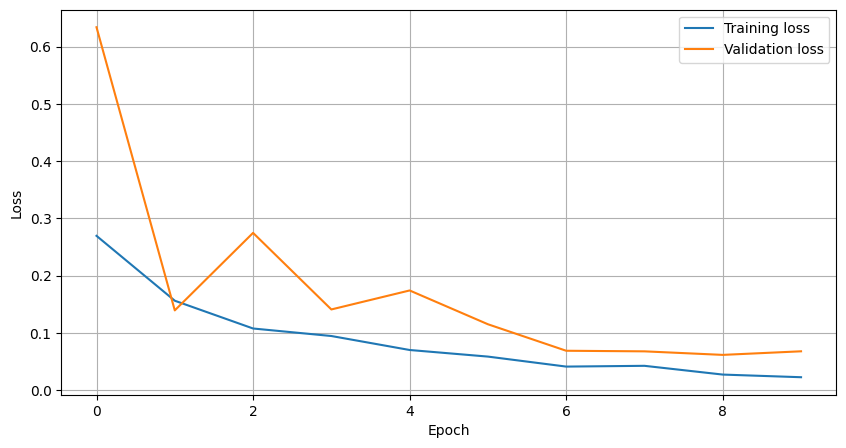

Training finished. Best model saved to: ./icecream_pizza_model_aug_2.pt
Test Accuracy: 0.9906


In [24]:
for i, tr in enumerate(tr_list):
  print(">>>>>>", desc_list[i])
  model = get_model(device)
  train_data = torchvision.datasets.ImageFolder(train_dir, transform=tr)
  valid_data = torchvision.datasets.ImageFolder(valid_dir, transform=test_transforms)
  train_model(model, train_data, valid_data, save_path=f"./icecream_pizza_model_aug_{i}.pt")
  test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
  acc_list.append(test_model(model, test_data))


In [25]:
df['descr'] = desc_list
df['accuracy'] = acc_list

df.head(3)


descr  accuracy
0  torchvision augs: colorJitter >> do color chan...  0.971698
1  torchvision augs: RandomAffine + RandomPerspec...  0.990566
2  torchvision augs - The RandomErasing() transfo...  0.990566

## Функция для предсказания на новом изображении


In [26]:
def predict_image(image_path, model_path="./icecream_pizza_model.pt", device=None):
    """
    Предсказывает класс изображения (мороженое или пицца)
    
    Args:
        image_path: путь к изображению
        model_path: путь к сохраненной модели
        device: устройство для вычислений (cpu/cuda)
    
    Returns:
        pred_class: название класса
        confidence: уверенность в процентах
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Загружаем модель
    print("Loading ResNet18 without pretrained weights...")
    model = get_model(device)
    
    # Загружаем веса модели
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Определяем классы (в алфавитном порядке: icecream=0, pizza=1)
    class_names = ['icecream', 'pizza']
    
    # Трансформации для изображения
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Загружаем и обрабатываем изображение
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Делаем предсказание
    with torch.no_grad():
        logps = model(image_tensor)
        ps = torch.exp(logps)
        prob, pred = ps.topk(1, dim=1)
    
    pred_class = class_names[pred.item()]
    confidence = prob.item() * 100
    
    # Выводим результат
    print(f"Предсказание: {pred_class}")
    print(f"Уверенность: {confidence:.1f}%")
    
    # Показываем изображение
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Предсказание: {pred_class}\nУверенность: {confidence:.1f}%", 
              fontsize=16, fontweight='bold')
    plt.show()
    
    return pred_class, confidence


### Пример использования функции предсказания


Loading ResNet18 without pretrained weights...
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen
Предсказание: pizza
Уверенность: 100.0%


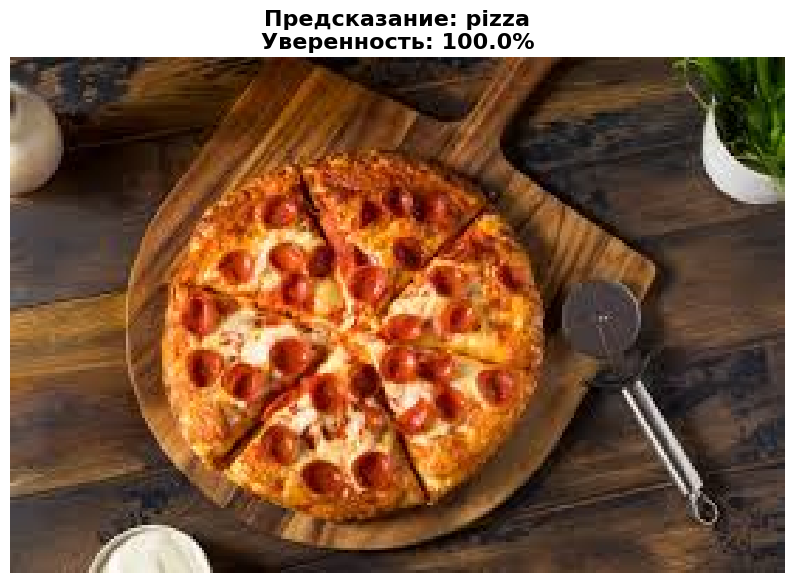

('pizza', 100.0)

In [36]:
# Можно также использовать на любом изображении по пути
predict_image("pizza.jpeg", model_path="./icecream_pizza_model.pt")


## Сравнение моделей на разных размерах данных


In [37]:
from torch.utils.data import Subset
import random

def create_subset_dataset(full_dataset, subset_size, seed=42):
    """
    Создает подмножество датасета заданного размера
    
    Args:
        full_dataset: полный датасет
        subset_size: размер подмножества (количество изображений)
        seed: seed для воспроизводимости
    
    Returns:
        subset_dataset: подмножество датасета
    """
    random.seed(seed)
    np.random.seed(seed)
    
    total_size = len(full_dataset)
    subset_size = min(subset_size, total_size)
    
    # Создаем случайные индексы
    indices = list(range(total_size))
    random.shuffle(indices)
    subset_indices = indices[:subset_size]
    
    subset_dataset = Subset(full_dataset, subset_indices)
    return subset_dataset

# Проверяем размеры данных
full_train_data = datasets.ImageFolder(train_dir, transform=tr)
print(f"Полный размер обучающего набора: {len(full_train_data)} изображений")
print(f"Классы: {full_train_data.classes}")


Полный размер обучающего набора: 718 изображений
Классы: ['icecream', 'pizza']


In [38]:
def compare_models_on_different_sizes(train_dir, valid_dir, test_dir, 
                                       sizes=[50, 150, 300, 500], 
                                       epochs=10, batch_size=16):
    """
    Сравнивает модели, обученные на разных размерах данных
    
    Args:
        train_dir: путь к обучающему набору
        valid_dir: путь к валидационному набору
        test_dir: путь к тестовому набору
        sizes: список размеров подмножеств для обучения
        epochs: количество эпох обучения
        batch_size: размер батча
    
    Returns:
        results_df: DataFrame с результатами сравнения
    """
    results = []
    
    # Трансформации
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Загружаем полные датасеты
    full_train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    valid_data = datasets.ImageFolder(valid_dir, transform=test_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)
    
    print(f"Полный размер обучающего набора: {len(full_train_data)} изображений")
    print(f"Размер валидационного набора: {len(valid_data)} изображений")
    print(f"Размер тестового набора: {len(test_data)} изображений\n")
    
    # Обучаем модели на разных размерах
    for size in sizes:
        if size > len(full_train_data):
            print(f"⚠ Размер {size} больше доступных данных ({len(full_train_data)}). Пропускаем.")
            continue
            
        print(f"{'='*60}")
        print(f"Обучаем модель на {size} изображениях")
        print(f"{'='*60}")
        
        # Создаем подмножество
        subset_train = create_subset_dataset(full_train_data, size)
        
        # Создаем модель
        model = get_model(device)
        
        # Обучаем модель
        save_path = f"./icecream_pizza_model_size_{size}.pt"
        train_model(model, subset_train, valid_data, 
                   epochs=epochs, batch_size=batch_size, save_path=save_path)
        
        # Тестируем модель
        test_acc = test_model(model, test_data, batch_size=batch_size)
        
        # Сохраняем результаты
        results.append({
            'Размер данных': size,
            'Процент данных': f"{size/len(full_train_data)*100:.1f}%",
            'Точность на тесте': f"{test_acc*100:.2f}%",
            'Точность (число)': test_acc
        })
        
        print(f"\n✅ Модель обучена на {size} изображениях. Точность: {test_acc*100:.2f}%\n")
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    return results_df


Размеры данных для сравнения:
  Маленький: 71 изображений (9.9%)
  Средний: 215 изображений (29.9%)
  Большой: 430 изображений (59.9%)
  Полный: 718 изображений (100.0%)

Начинаем обучение...

Полный размер обучающего набора: 718 изображений
Размер валидационного набора: 208 изображений
Размер тестового набора: 106 изображений

Обучаем модель на 71 изображениях
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


Epoch 1/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]



Epoch 1/10 | Train Loss: 0.3764 | Val Loss: 0.2999 | Val Acc: 0.9231
Validation loss improved inf → 0.2999. Saving model.


Epoch 2/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]



Epoch 2/10 | Train Loss: 0.3304 | Val Loss: 0.4936 | Val Acc: 0.8894


Epoch 3/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]



Epoch 3/10 | Train Loss: 0.0836 | Val Loss: 0.2882 | Val Acc: 0.8990
Validation loss improved 0.2999 → 0.2882. Saving model.


Epoch 4/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]



Epoch 4/10 | Train Loss: 0.2141 | Val Loss: 0.4713 | Val Acc: 0.8894


Epoch 5/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]



Epoch 5/10 | Train Loss: 0.0573 | Val Loss: 0.5655 | Val Acc: 0.8894


Epoch 6/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]



Epoch 6/10 | Train Loss: 0.0278 | Val Loss: 0.2984 | Val Acc: 0.9279


Epoch 7/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 7/10 | Train Loss: 0.0097 | Val Loss: 0.2327 | Val Acc: 0.9183
Validation loss improved 0.2882 → 0.2327. Saving model.


Epoch 8/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 8/10 | Train Loss: 0.0124 | Val Loss: 0.2355 | Val Acc: 0.9183


Epoch 9/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 9/10 | Train Loss: 0.0116 | Val Loss: 0.2347 | Val Acc: 0.9279


Epoch 10/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 10/10 | Train Loss: 0.0067 | Val Loss: 0.2270 | Val Acc: 0.9279
Validation loss improved 0.2327 → 0.2270. Saving model.


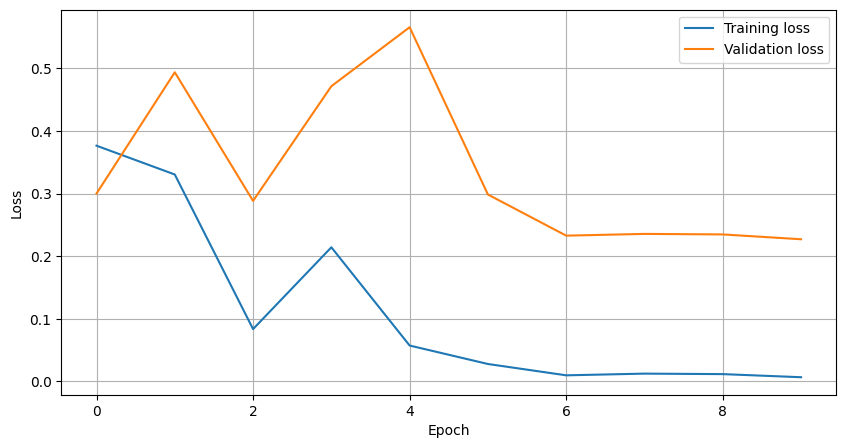

Training finished. Best model saved to: ./icecream_pizza_model_size_71.pt
Test Accuracy: 0.9151

✅ Модель обучена на 71 изображениях. Точность: 91.51%

Обучаем модель на 215 изображениях
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


Epoch 1/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]



Epoch 1/10 | Train Loss: 0.2836 | Val Loss: 1.6611 | Val Acc: 0.8413
Validation loss improved inf → 1.6611. Saving model.


Epoch 2/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]



Epoch 2/10 | Train Loss: 0.2244 | Val Loss: 0.2967 | Val Acc: 0.9327
Validation loss improved 1.6611 → 0.2967. Saving model.


Epoch 3/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]



Epoch 3/10 | Train Loss: 0.0700 | Val Loss: 0.5249 | Val Acc: 0.8846


Epoch 4/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]



Epoch 4/10 | Train Loss: 0.1199 | Val Loss: 0.1588 | Val Acc: 0.9567
Validation loss improved 0.2967 → 0.1588. Saving model.


Epoch 5/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]



Epoch 5/10 | Train Loss: 0.0703 | Val Loss: 0.8711 | Val Acc: 0.7933


Epoch 6/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]



Epoch 6/10 | Train Loss: 0.0583 | Val Loss: 1.3147 | Val Acc: 0.7163


Epoch 7/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]



Epoch 7/10 | Train Loss: 0.1395 | Val Loss: 0.1522 | Val Acc: 0.9423
Validation loss improved 0.1588 → 0.1522. Saving model.


Epoch 8/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]



Epoch 8/10 | Train Loss: 0.0259 | Val Loss: 0.1116 | Val Acc: 0.9519
Validation loss improved 0.1522 → 0.1116. Saving model.


Epoch 9/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]



Epoch 9/10 | Train Loss: 0.0217 | Val Loss: 0.1072 | Val Acc: 0.9567
Validation loss improved 0.1116 → 0.1072. Saving model.


Epoch 10/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 10/10 | Train Loss: 0.0373 | Val Loss: 0.1094 | Val Acc: 0.9615


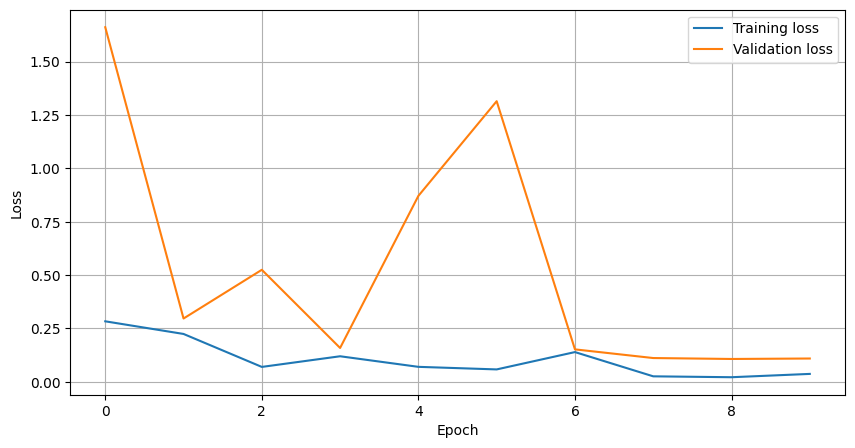

Training finished. Best model saved to: ./icecream_pizza_model_size_215.pt
Test Accuracy: 0.9623

✅ Модель обучена на 215 изображениях. Точность: 96.23%

Обучаем модель на 430 изображениях
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


Epoch 1/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]



Epoch 1/10 | Train Loss: 0.2994 | Val Loss: 0.2589 | Val Acc: 0.8798
Validation loss improved inf → 0.2589. Saving model.


Epoch 2/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]



Epoch 2/10 | Train Loss: 0.2067 | Val Loss: 0.2000 | Val Acc: 0.9567
Validation loss improved 0.2589 → 0.2000. Saving model.


Epoch 3/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 3/10 | Train Loss: 0.0748 | Val Loss: 0.1536 | Val Acc: 0.9567
Validation loss improved 0.2000 → 0.1536. Saving model.


Epoch 4/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]



Epoch 4/10 | Train Loss: 0.0979 | Val Loss: 0.1778 | Val Acc: 0.9231


Epoch 5/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]



Epoch 5/10 | Train Loss: 0.0794 | Val Loss: 0.3901 | Val Acc: 0.9038


Epoch 6/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]



Epoch 6/10 | Train Loss: 0.0853 | Val Loss: 0.2266 | Val Acc: 0.9183


Epoch 7/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 7/10 | Train Loss: 0.0188 | Val Loss: 0.1150 | Val Acc: 0.9519
Validation loss improved 0.1536 → 0.1150. Saving model.


Epoch 8/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 8/10 | Train Loss: 0.0173 | Val Loss: 0.1075 | Val Acc: 0.9663
Validation loss improved 0.1150 → 0.1075. Saving model.


Epoch 9/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]



Epoch 9/10 | Train Loss: 0.0346 | Val Loss: 0.1029 | Val Acc: 0.9712
Validation loss improved 0.1075 → 0.1029. Saving model.


Epoch 10/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 10/10 | Train Loss: 0.0254 | Val Loss: 0.1490 | Val Acc: 0.9519


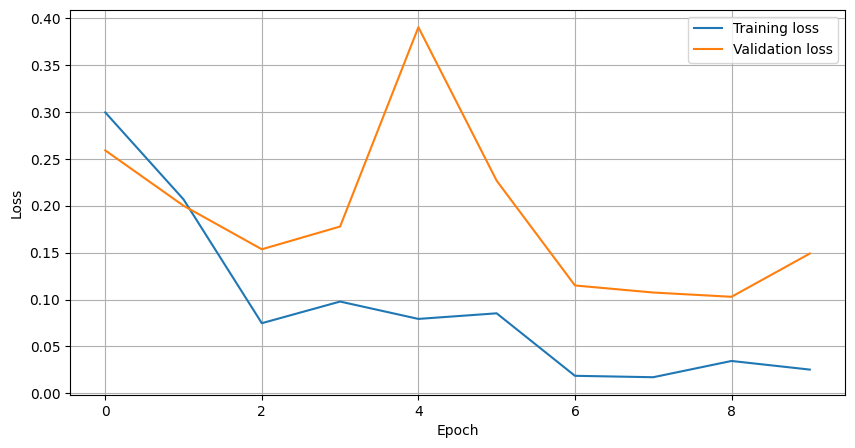

Training finished. Best model saved to: ./icecream_pizza_model_size_430.pt
Test Accuracy: 0.9717

✅ Модель обучена на 430 изображениях. Точность: 97.17%

Обучаем модель на 718 изображениях
conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


Epoch 1/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 1/10 | Train Loss: 0.2746 | Val Loss: 0.2214 | Val Acc: 0.9183
Validation loss improved inf → 0.2214. Saving model.


Epoch 2/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]



Epoch 2/10 | Train Loss: 0.1467 | Val Loss: 0.2321 | Val Acc: 0.9135


Epoch 3/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 3/10 | Train Loss: 0.0885 | Val Loss: 0.4561 | Val Acc: 0.8606


Epoch 4/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 4/10 | Train Loss: 0.1287 | Val Loss: 0.6427 | Val Acc: 0.8654


Epoch 5/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]



Epoch 5/10 | Train Loss: 0.1754 | Val Loss: 0.1598 | Val Acc: 0.9615
Validation loss improved 0.2214 → 0.1598. Saving model.


Epoch 6/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]



Epoch 6/10 | Train Loss: 0.0346 | Val Loss: 0.3621 | Val Acc: 0.9087


Epoch 7/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]



Epoch 7/10 | Train Loss: 0.0154 | Val Loss: 0.1793 | Val Acc: 0.9519


Epoch 8/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]



Epoch 8/10 | Train Loss: 0.0137 | Val Loss: 0.1433 | Val Acc: 0.9615
Validation loss improved 0.1598 → 0.1433. Saving model.


Epoch 9/10 [val]: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]



Epoch 9/10 | Train Loss: 0.0051 | Val Loss: 0.1776 | Val Acc: 0.9471


Epoch 10/10 [val]: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch 10/10 | Train Loss: 0.0186 | Val Loss: 0.1330 | Val Acc: 0.9663
Validation loss improved 0.1433 → 0.1330. Saving model.


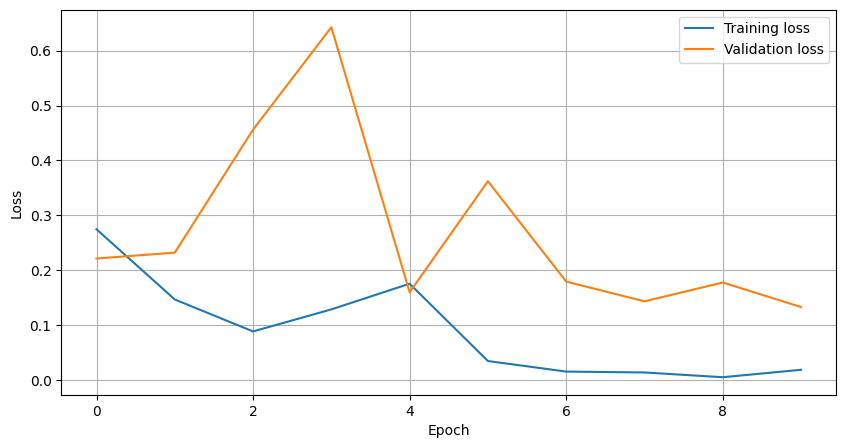

Training finished. Best model saved to: ./icecream_pizza_model_size_718.pt
Test Accuracy: 0.9717

✅ Модель обучена на 718 изображениях. Точность: 97.17%



In [39]:
# Запускаем сравнение моделей
# Определяем размеры: маленький, средний, большой
total_train_size = len(datasets.ImageFolder(train_dir, transform=tr))
sizes = [
    int(total_train_size * 0.1),  # 10% - маленький (~72 изображения)
    int(total_train_size * 0.3),   # 30% - средний (~215 изображений)
    int(total_train_size * 0.6),   # 60% - большой (~430 изображений)
    total_train_size               # 100% - полный набор (~718 изображений)
]

print("Размеры данных для сравнения:")
for i, size in enumerate(sizes):
    print(f"  {['Маленький', 'Средний', 'Большой', 'Полный'][i]}: {size} изображений ({size/total_train_size*100:.1f}%)")

print("\nНачинаем обучение...\n")
results_df = compare_models_on_different_sizes(
    train_dir=train_dir,
    valid_dir=valid_dir,
    test_dir=test_dir,
    sizes=sizes,
    epochs=10,
    batch_size=16
)


In [40]:
# Выводим таблицу результатов
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)



РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ
 Размер данных Процент данных Точность на тесте  Точность (число)
            71           9.9%            91.51%          0.915094
           215          29.9%            96.23%          0.962264
           430          59.9%            97.17%          0.971698
           718         100.0%            97.17%          0.971698


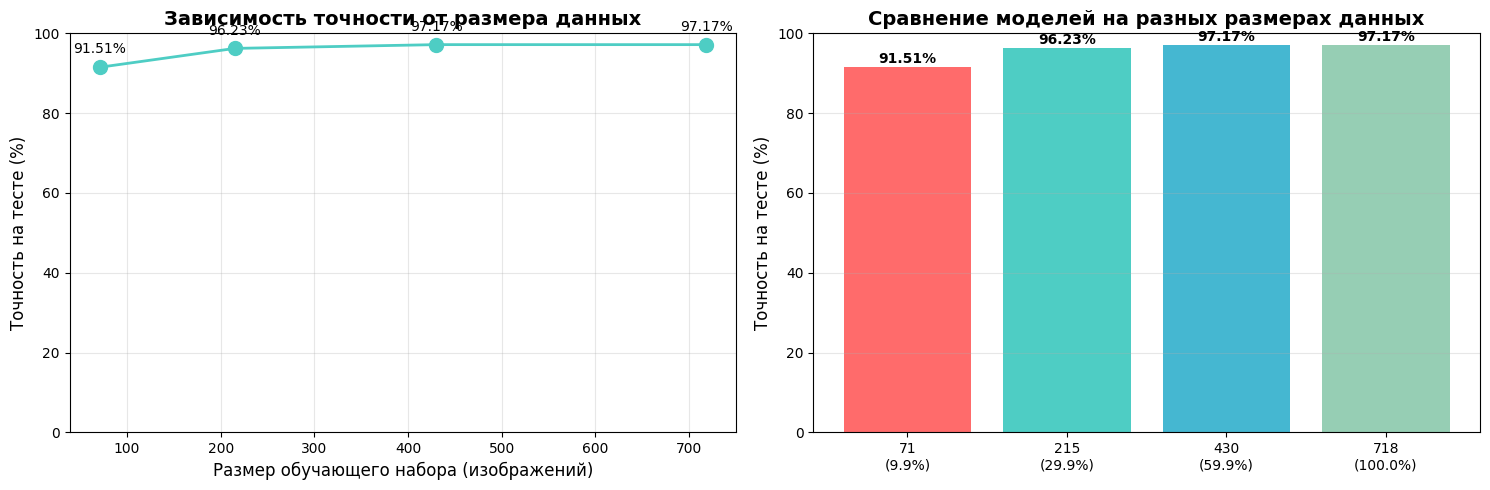


ВЫВОДЫ:
✅ Лучшая модель: обучена на 430 изображениях (59.9%)
   Точность: 97.17%

📈 Прирост точности от маленького к полному набору: +5.66%
   💡 Использование большего количества данных значительно улучшает модель


In [41]:
# Визуализация результатов сравнения
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График 1: Точность в зависимости от размера данных
axes[0].plot(results_df['Размер данных'], results_df['Точность (число)'] * 100, 
             marker='o', linewidth=2, markersize=10, color='#4ECDC4')
axes[0].set_xlabel('Размер обучающего набора (изображений)', fontsize=12)
axes[0].set_ylabel('Точность на тесте (%)', fontsize=12)
axes[0].set_title('Зависимость точности от размера данных', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 100])

# Добавляем аннотации
for idx, row in results_df.iterrows():
    axes[0].annotate(f"{row['Точность на тесте']}", 
                     (row['Размер данных'], row['Точность (число)'] * 100),
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

# График 2: Столбчатая диаграмма
size_labels = [f"{row['Размер данных']}\n({row['Процент данных']})" 
               for _, row in results_df.iterrows()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
axes[1].bar(range(len(results_df)), results_df['Точность (число)'] * 100, 
            color=colors[:len(results_df)])
axes[1].set_xticks(range(len(results_df)))
axes[1].set_xticklabels(size_labels, fontsize=10)
axes[1].set_ylabel('Точность на тесте (%)', fontsize=12)
axes[1].set_title('Сравнение моделей на разных размерах данных', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 100])

# Добавляем значения на столбцы
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[1].text(i, row['Точность (число)'] * 100 + 1, 
                row['Точность на тесте'], ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Выводим выводы
print("\n" + "="*60)
print("ВЫВОДЫ:")
print("="*60)
best_idx = results_df['Точность (число)'].idxmax()
best_row = results_df.loc[best_idx]
print(f"✅ Лучшая модель: обучена на {best_row['Размер данных']} изображениях ({best_row['Процент данных']})")
print(f"   Точность: {best_row['Точность на тесте']}")

# Сравнение прироста
if len(results_df) > 1:
    small_acc = results_df.iloc[0]['Точность (число)']
    large_acc = results_df.iloc[-1]['Точность (число)']
    improvement = (large_acc - small_acc) * 100
    print(f"\n📈 Прирост точности от маленького к полному набору: +{improvement:.2f}%")
    
    # Проверяем, стоит ли использовать больше данных
    if improvement > 5:
        print("   💡 Использование большего количества данных значительно улучшает модель")
    elif improvement > 2:
        print("   💡 Использование большего количества данных немного улучшает модель")
    else:
        print("   💡 Прирост незначителен, возможно стоит использовать меньше данных для экономии времени")
print("="*60)
